Fashion Forward is a new AI-based e-commerce clothing retailer.
They want to use image classification to automatically categorize new product listings, making it easier for customers to find what they're looking for. It will also assist in inventory management by quickly sorting items.

As a data scientist tasked with implementing a garment classifier, your primary objective is to develop a machine learning model capable of accurately categorizing images of clothing items into distinct garment types such as shirts, trousers, shoes, etc.


## Importing Required Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy, Precision, Recall

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Loading the dataset

In [2]:
# Load datasets
from torchvision import datasets
import torchvision.transforms as transforms

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:01<00:00, 17182395.13it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 272384.97it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5113692.85it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10905190.40it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## Loading the data into DataLoader

In [3]:
classes = train_data.classes
num_classes = len(train_data.classes)
dataloader_train = DataLoader(
                            train_data,
                            batch_size=10,
                            shuffle=True)

In [4]:
dataloader_test = DataLoader(
                            test_data,
                            batch_size=10,
                            shuffle=True)

## Checking out the Training Data

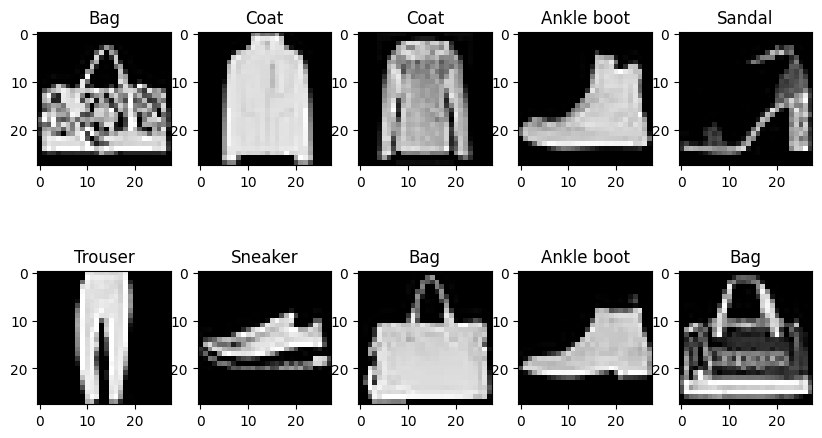

In [5]:
images, labels = next(iter(dataloader_train))

import matplotlib.pyplot as plt
count = 1
plt.figure(figsize=(10,15))
for image, label in zip(images, labels):
    plt.subplot(5, 5, count)
    plt.title(classes[label.item()])
    plt.imshow(image.squeeze(), cmap='gray')
    count +=1
plt.show()

## Designing the Classifier Network

In [6]:


class FashionClassifier(nn.Module):
    def __init__(self, num_classes):
        super(FashionClassifier, self).__init__()
        self.feature_extracter = nn.Sequential(
                                    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2),
                                    nn.Flatten())
        self.classifier = nn.Sequential(
                                    nn.Linear(32 * 14 * 14, num_classes),
                                    nn.Softmax(dim=1))  # Adjust the input size here

    def forward(self, x):
        x = self.feature_extracter(x)
        x = self.classifier(x)
        return x


## Initializng the Network Module

In [7]:
net = FashionClassifier(num_classes)
net

FashionClassifier(
  (feature_extracter): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
)

## Training the network

In [8]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):  # Change the loop variable
    losses = 0
    steps = 0
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = net(images)  # Add unsqueeze to add batch dimension
        loss = criterion(outputs, labels)  # Convert labels to tensor
        loss.backward()
        optimizer.step()
        losses+=loss
        steps += len(labels)
    print(f"Epoch {epoch+1}: loss {losses/steps}")



Epoch 1: loss 0.1760077178478241
Epoch 2: loss 0.16474035382270813
Epoch 3: loss 0.1566665917634964
Epoch 4: loss 0.1558217704296112
Epoch 5: loss 0.15525583922863007
Epoch 6: loss 0.15476331114768982
Epoch 7: loss 0.1543571501970291
Epoch 8: loss 0.15404649078845978
Epoch 9: loss 0.15377570688724518
Epoch 10: loss 0.15360179543495178


## Defining metrics for Test Data Performance

In [9]:
accuracy_metric = Accuracy(task='multiclass', num_classes=num_classes)
precision_metric = Precision(task='multiclass', num_classes=num_classes, average='none')
recall_metric = Recall(task='multiclass', num_classes=num_classes, average='none')


## Testing the Model

In [10]:
predictions = []

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        cat = torch.argmax(outputs, 1)
        predictions.extend(cat.tolist())
        accuracy_metric(cat, labels)
        precision_metric(cat, labels)
        recall_metric(cat, labels)
        
accuracy = accuracy_metric.compute().item()
precision = precision_metric.compute().tolist()
recall = recall_metric.compute().tolist()

print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}")

Accuracy: 0.9002000093460083
Precision: [0.8539553880691528, 0.9838220477104187, 0.8825430870056152, 0.8726415038108826, 0.8727465271949768, 0.9887179732322693, 0.6866484880447388, 0.9499509334564209, 0.9717457294464111, 0.961309552192688]
Recall: [0.8420000076293945, 0.9729999899864197, 0.8190000057220459, 0.925000011920929, 0.8230000138282776, 0.9639999866485596, 0.7559999823570251, 0.9679999947547913, 0.9629999995231628, 0.968999981880188]


In [11]:
torch.save(net.state_dict(), "FashionClassifier.pt")